<a href="https://colab.research.google.com/github/laurauguc/bayesian_time_series/blob/main/Time_Series_with_Stan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Simulations

Latest update: 2024-11-07

# Table of Contents

1. [Introduction](#introduction)
2. [Set-Up](#setup)
3. [Background](#background)
4. [Approach](#approach)
5. [Implementation](#implementation)
6. [Conclusion](#conclusion)

# 1. Introduction <a name="introduction"></a>

This notebook evaluates a Bayesian time series model built in Stan, comparing its predictions to those from a frequentist counterpart in Python’s `stats` library. The primary goal is educational: to understand the conditions under which Bayesian and frequentist predictions align and to deepen my understanding of the mathematical principles underlying time series modeling.

By constructing this model in Stan, where each component—from the likelihood function to parameter distributions—is manually specified, I’ve gained valuable insights into Bayesian statistics and the fundamentals of time series analysis. A secondary objective of this notebook is to illustrate key concepts in both time series and Bayesian modeling.

Working with Stan brought its share of challenges, such as convergence issues and visualizing posterior samples effectively. Although sometimes frustrating, these challenges reinforced my foundations in computational and applied mathematics. Practical drawbacks also arose—frequent installation issues on Mac and Windows, for instance. To streamline the process, I’m developing this notebook in Google Colab, where Stan is readily accessible, though installation remains somewhat slow.

## 2. Set-Up <a name="setup"></a>

In [ ]:
options(warn=-1)

# need to install the forecast package before rstan to avoid erros
suppressMessages(install.packages("forecast"))
# to install Stan first need to install the V8 package via the command line
system('sudo apt-get install -y libv8-dev')
# then install rstan in R folder on the Google server (see lib parameter)
suppressMessages(install.packages("rstan", dependencies = T, repos = "https://cloud.r-project.org", lib = "/usr/lib/R/library",))
suppressMessages(install.packages("tidyr"))

# load libraries
suppressPackageStartupMessages(library(forecast))
suppressPackageStartupMessages(library(rstan))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stats))
suppressPackageStartupMessages(library(lmtest))

# stan options
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

# plot options
options(repr.plot.width=20, repr.plot.height = 20, repr.plot.height=5)

# download helpful files and unzip
download.file("https://github.com/laurauguc/bayesian_time_series/raw/refs/heads/main/stan_models.zip", destfile = 'bayesian_time_series.zip')
unzip("bayesian_time_series.zip")
download.file("https://github.com/laurauguc/bayesian_time_series/raw/refs/heads/main/utils.R", destfile = "utils.R")

# source utils and set seed
#source("utils.R")
set.seed(123) # For reproducibility

In [ ]:
# Bayesian ARIMA function
bayesian_arima <- function(x, order, h) {
  d <- order[2]
  if (d > 0) {
    x_diff <- difference(x, d)
    stan_data <- list(num_obs = length(x_diff), y = x_diff, p = order[1], q = order[3], h = h)
  } else {
    stan_data <- list(num_obs = length(x), y = x, p = order[1], q = order[3], h = h)
  }
  stan_fit <- rstan::stan(file = 'stan_models/ARMA_simple.stan', data = stan_data)
  return(stan_fit)
}

# Reverse differencing helper function
reverse_differencing <- function(y, x_observed, d) {
  if (d > 0) {
    for (i in d:1) {
      x_observed_diff <- difference(x_observed, i - 1)
      y <- y + x_observed_diff[length(x_observed_diff)]
    }
  }
  return(y)
}

# Obtain mean predictions from Bayesian fit
obtain_mean_pred <- function(bayesian_fit, x_observed, d, h) {
  y_fit <- rstan::extract(bayesian_fit, 'y_fit')$y_fit
  y_pred <- rstan::extract(bayesian_fit, 'y_pred')$y_pred

  if (d > 0) {
    y_fit <- reverse_differencing(y_fit, x_observed, d)
    y_pred <- reverse_differencing(y_pred, x_observed, d)
  }

  y_pred_mean <- colMeans(cbind(y_fit, y_pred))
  return(y_pred_mean)
}

# Comparison plot function for frequentist and Bayesian predictions
comparison_plot <- function(frequentist_fit, bayesian_fit, x_observed, x_future) {
  h <- length(x_future)
  size <- length(x_observed) + h
  d <- length(frequentist_fit[["model"]][["Delta"]])
  x <- c(x_observed, x_future)

  # Frequentist predictions
  frequentist_y_fit <- c(fitted(frequentist_fit), rep(NA, h))
  frequentist_pred <- predict(frequentist_fit, n.ahead = h)
  frequentist_y_forecast <- c(rep(NA, size - h), frequentist_pred$pred)
  frequentist_pred_interval <- forecast(frequentist_fit, h = h, level = 90)
  frequentist_ub <- c(fitted(frequentist_fit) + 1.64 * sqrt(frequentist_fit$sigma2),
                      frequentist_pred_interval[["upper"]])
  frequentist_lb <- c(fitted(frequentist_fit) - 1.64 * sqrt(frequentist_fit$sigma2),
                      frequentist_pred_interval[["lower"]])

  # Bayesian predictions
  y_pred_mean <- obtain_mean_pred(bayesian_fit, x_observed, d, h)
  y_fit_mean <- replace(y_pred_mean, (size - h + 1):length(y_pred_mean), NA)
  y_forecast_mean <- replace(y_pred_mean, 1:(size - h), NA)

  # Bayesian credible intervals
  y_fit <- rstan::extract(bayesian_fit, 'y_fit')$y_fit
  y_pred <- rstan::extract(bayesian_fit, 'y_pred')$y_pred
  y_pred_sims <- cbind(y_fit, y_pred)
  y_pred_lb <- apply(y_pred_sims, 2, function(x) quantile(x, probs = 0.05))
  y_pred_ub <- apply(y_pred_sims, 2, function(x) quantile(x, probs = 0.95))

  # Plot
  p <- ggplot(mapping = aes(x = 1:size)) +
    geom_ribbon(aes(ymin = y_pred_lb, ymax = y_pred_ub, fill = "Bayesian credible interval"), alpha = 0.2) +
    geom_ribbon(aes(ymin = frequentist_lb, ymax = frequentist_ub, fill = "Frequentist prediction interval"), alpha = 0.2) +
    geom_line(aes(y = y_fit_mean, linetype = "In-sample (Fitted values)", color = "Bayesian")) +
    geom_line(aes(y = y_forecast_mean, linetype = "Out-of-sample (Forecasted values)", color = "Bayesian")) +
    geom_line(aes(y = frequentist_y_fit, linetype = "In-sample (Fitted values)", color = "Frequentist")) +
    geom_line(aes(y = frequentist_y_forecast, linetype = "Out-of-sample (Forecasted values)", color = "Frequentist")) +
    geom_point(aes(y = x_observed, x = 1:(size - h), shape = 'Training')) +
    geom_point(aes(y = x_future, x = (size - h + 1):size, shape = 'Testing')) +
    xlab("Simulation #") + ylab("Value") +
    scale_fill_manual(name = "90% Interval", values = c("Bayesian credible interval" = "blue", "Frequentist prediction interval" = "orange")) +
    scale_shape_manual(name = "Simulated datasets", values = c("Training" = 20, "Testing" = 21)) +
    scale_linetype_manual(name = "Prediction type", values = c("solid", "dashed")) +
    scale_colour_manual(name = "Statistical paradigm", values = c("blue", "orange"))

  return(p)
}

obtain_mean_pred <- function(bayesian_fit, x, d, h) {
  # Extract dimensions of parameters
  p <- bayesian_fit@par_dims[["phi"]]
  q <- bayesian_fit@par_dims[["theta"]]

  # Extract posterior samples for sigma, phi, and theta
  sigma_sims <- rstan::extract(bayesian_fit, "sigma")$sigma
  phi_sims_mean <- if (p) apply(rstan::extract(bayesian_fit, "phi")$phi, 2, mean) else NULL
  theta_sims_mean <- if (q) apply(rstan::extract(bayesian_fit, "theta")$theta, 2, mean) else NULL

  # Apply differencing if needed
  x_orig <- x
  if (d) x <- difference(x, d)
  T <- length(x)

  # Initialize fitted values and errors
  x_fit_mean <- numeric(T)
  err_mean <- numeric(T)

  # Generate in-sample fitted values
  for (t in 2:T) {
    eta <- 0
    if (p) for (i in 1:min(p, t - 1)) eta <- eta + x[t - i] * phi_sims_mean[i]
    if (q) for (i in 1:min(q, t - 1)) eta <- eta + err_mean[t - i] * theta_sims_mean[i]
    x_fit_mean[t] <- eta
    err_mean[t] <- x[t] - x_fit_mean[t]
  }

  # Reverse differencing for in-sample fitted values
  if (d) {
    for (i in seq_len(d)) {
      x_above <- difference(x_orig, i - 1)
      x_fit_mean <- reverse_diff_other_vector(x_fit_mean, x_above)
    }
  }

  # Forecast future values
  x_forecast_mean <- numeric(h)
  for (t in seq_len(h)) {
    eta <- 0
    if (p) {
      p_new <- min(t - 1, p)
      p_rem <- p - p_new
      for (i in seq_len(p_new)) eta <- eta + x_forecast_mean[t - i] * phi_sims_mean[i]
      for (i in seq_len(p_rem)) eta <- eta + x[T + 1 - i] * phi_sims_mean[i + p_new]
    }
    if (q) {
      q_rem <- q - min(t - 1, q)
      for (i in seq_len(q_rem)) eta <- eta + err_mean[T + 1 - i] * theta_sims_mean[i]
    }
    x_forecast_mean[t] <- eta
  }

  # Reverse differencing for forecast values
  if (d) {
    for (i in seq_len(d)) {
      x_above <- difference(x_orig, i - 1)
      x_forecast_mean <- reverse_diff_forecast_mean(x_forecast_mean, x_above[length(x_above)])
    }
  }

  # Combine in-sample fitted values and forecasted values
  y_pred_mean <- c(x_fit_mean, x_forecast_mean)
  return(y_pred_mean)
}

# Differencing and Reverse Differencing Functions

difference <- function(x, d) {
  for (i in seq_len(d)) x <- diff(x)
  return(x)
}

reverse_diff_forecast_mean <- function(x_diff, init_value) {
  x_diff[1] <- x_diff[1] + init_value
  return(cumsum(x_diff))
}

reverse_diff_other_vector <- function(x_diff_fit, x_actual) {
  return(cumsum(c(x_actual[1], x_diff_fit)) + c(x_actual[1], x_actual[-length(x_actual)]))
}

reverse_differencing_y_fit <- function(y_fit, y) {
  y_fit <- sweep(cbind(rep_len(0, nrow(y_fit)), y_fit), 2, c(y[1], y[-length(y)]), "+")
  return(y_fit)
}

reverse_differencing_y_forecast <- function(y_pred, y) {
  y_pred[, 1] <- y_pred[, 1] + y[length(y)]
  for (i in 2:ncol(y_pred)) y_pred[, i] <- y_pred[, i] + y_pred[, i - 1]
  return(y_pred)
}

# 3. Background <a name="background"></a>

### Bayesian vs. Frequentist Paradigms in Statistics

Statistics typically follows two paradigms: **frequentist** and **Bayesian**. While most introductory courses focus on the frequentist approach, Bayesian statistics, dating back to the 1700s, has gained traction with advancements in computational power. These advancements allow us to solve complex integrals without analytical solutions, enabling custom Bayesian models—one of the paradigm's main advantages. The key distinction between these approaches lies in how each interprets probability.

- **Frequentist Interpretation:** Probability represents the relative frequency of an event in repeated trials.
- **Bayesian Interpretation:** Probability represents a degree of belief, making it a more intuitive approach for certain applications.

This seemingly innocuous fundamental difference results in vastly different model-building approaches and interpretation of results.

For example, Bayesian statisticians use probability distributions to describe a wide range of values, including model parameters like $\alpha$ in $y = \alpha + \beta x$. In contrast, frequentists treat parameters as fixed values and only model the data generation process probabilistically. Frequentist inference typically relies on hypothesis testing, while Bayesian inference expresses uncertainty with probability distributions.

Some additional differences include:

- **Priors:** Bayesian models incorporate prior beliefs or expert knowledge, while this concept is foreign to frequentists.
- **Hypothesis Testing vs. Uncertainty Estimation:** Frequentists use hypothesis tests, while Bayesians provide probability-based uncertainty.
- **Model Customization:** Frequentists often rely on established hypothesis testing procedures, while Bayesian methods allow more flexibility by defining priors and likelihoods.

Under specific conditions, such as with flat (uninformative) priors, Bayesian models can produce predictions similar to frequentist models. However, Bayesian models offer added flexibility through priors and customizability, making them particularly useful in cases with complex data generation processes.

### What is Stan and Why Build Models with It?

Stan is a probabilistic programming language widely used for Bayesian inference, particularly valuable in fields like biostatistics, epidemiology, and social sciences. Its robust algorithms—such as Hamiltonian Monte Carlo (HMC) and the No-U-Turn Sampler (NUTS)—enable efficient exploration of complex models. This flexibility makes Stan ideal for hierarchical modeling, time series analysis, and Gaussian processes, offering a transparent, reproducible environment for model development.

Stan has been instrumental for me in two ways. First, it allows me to confirm my understanding of probabilistic models by defining their mathematical structures directly. Replicating a model in Stan is a rigorous test of both conceptual and technical mastery.

Additionally, Stan’s flexibility facilitates building models tailored to specific applications where existing models fall short. For instance, Facebook’s Prophet model, popular for time series analysis, benefits from Stan’s ability to handle complex time-series dependencies. Starting with a known model, replicating it in Stan, and adjusting it as needed provides a powerful framework for addressing unique modeling needs.

Helpful resources:
- [Stan website](https://mc-stan.org/)
- [Stan Introduction by Betancourt](https://betanalpha.github.io/assets/case_studies/stan_intro.html)

### The ARIMA Model

The Bayesian model we’ll build here is a Bayesian adaptation of the Autoregressive Integrated Moving Average (ARIMA) model, widely used for time series forecasting. Understanding the ARIMA model's underlying equations offers a solid foundation in time series analysis.

The general ARIMA model is represented as:

$$(1 - \sum^p_{i=1}\phi_iL^i)(1-L)^dX_t = (1+\sum^q_{i=1}\theta_i L^i) \epsilon_t $$

where \( L \) is the lag operator.

The ARIMA model has two primary components:

1) **Integration**: Transforming the series to stationarity through differencing, e.g., when $(d = 1)$, $((1-L)^dX_t)$ represents $( X_t - X_{t-1})$.
   
2) **ARMA Model**: Combining the autoregressive (AR) and moving average (MA) components.

In this notebook, we build and evaluate a Bayesian ARIMA model by setting flat priors for comparability with the frequentist ARIMA model.

# 4. Approach <a name="approach"></a>

The Bayesian ARIMA model is implemented in Stan and can be found here: `stan_models/ARIMA.stan`. This notebook documents the process of identifying and resolving modeling discrepancies until the Bayesian and frequentist results aligned.

To facilitate comparison, we use flat priors in the Bayesian model, effectively “neutralizing” the prior’s influence. While this omits one of the Bayesian model’s advantages—the ability to include prior information—it confirms the model’s specification. We then consider adding priors as an extension.

To identify and resolve discrepancies, I started with the simplest ARIMA model, the ARIMA(0,0,0) model, and progressively added complexity, until building a general ARIMA(p,d,q) model. The final Bayesian arima model that we'll be using (`stan_models/ARIMA.stan`) already reflects the resolved issues. Therefore, the results align with the `stats` library ARIMA model.

For each progressively more complex ARIMA model, we perform the following steps:

- Generate synthetic data with randomly chosen parameters
- Use the `stats` package and Bayesian ARIMA to estimate these parameters independently
- Compare and visualize results for consistency and insights

# 5. Implementation <a name="implementation"></a>

In [ ]:
# Parameters
size <- 1000
h <- 200

cat("Time series length: ", size, "\n")
cat("Forecasting horizon: ", h, " (segmented off of the overall time series length) \n")

Time series length:  1000 
Forecasting horizon:  200  (segmented off of the overall time series length) 


### Process 1: White Noise = ARIMA(0,0,0)

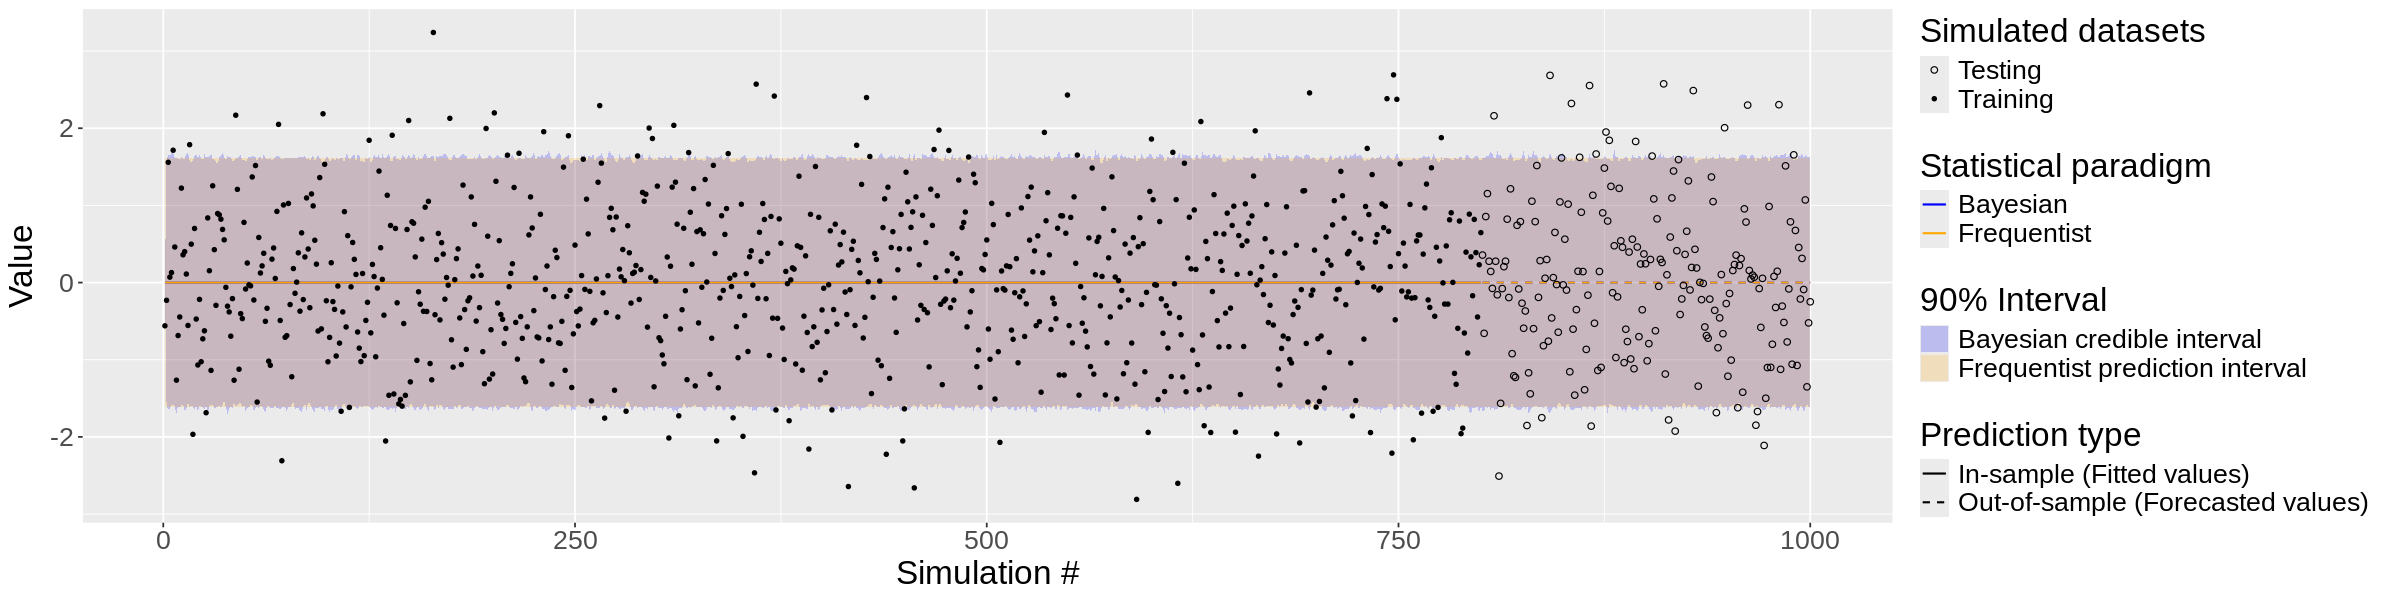

In [ ]:
# Generate a random time series and split into observed and future parts
time_series <- rnorm(size)
observed_data <- time_series[1:(size - h)]
future_data <- time_series[(size - h + 1):size]

# Set ARIMA model order
model_order <- c(0, 0, 0)

# Fit ARIMA model using frequentist and Bayesian methods
frequentist_fit <- arima(x = observed_data, order = model_order, include.mean = FALSE)
bayesian_fit <- bayesian_arima(x = observed_data, order = model_order, h = h)

# Create comparison plot of the two fits
p1 <- comparison_plot(frequentist_fit, bayesian_fit, observed_data, future_data)
p1 + theme(text = element_text(size = 20))

TK: Note on working with samples.

### Process 2: Auto Regressive 1 = ARIMA(1,0,0)

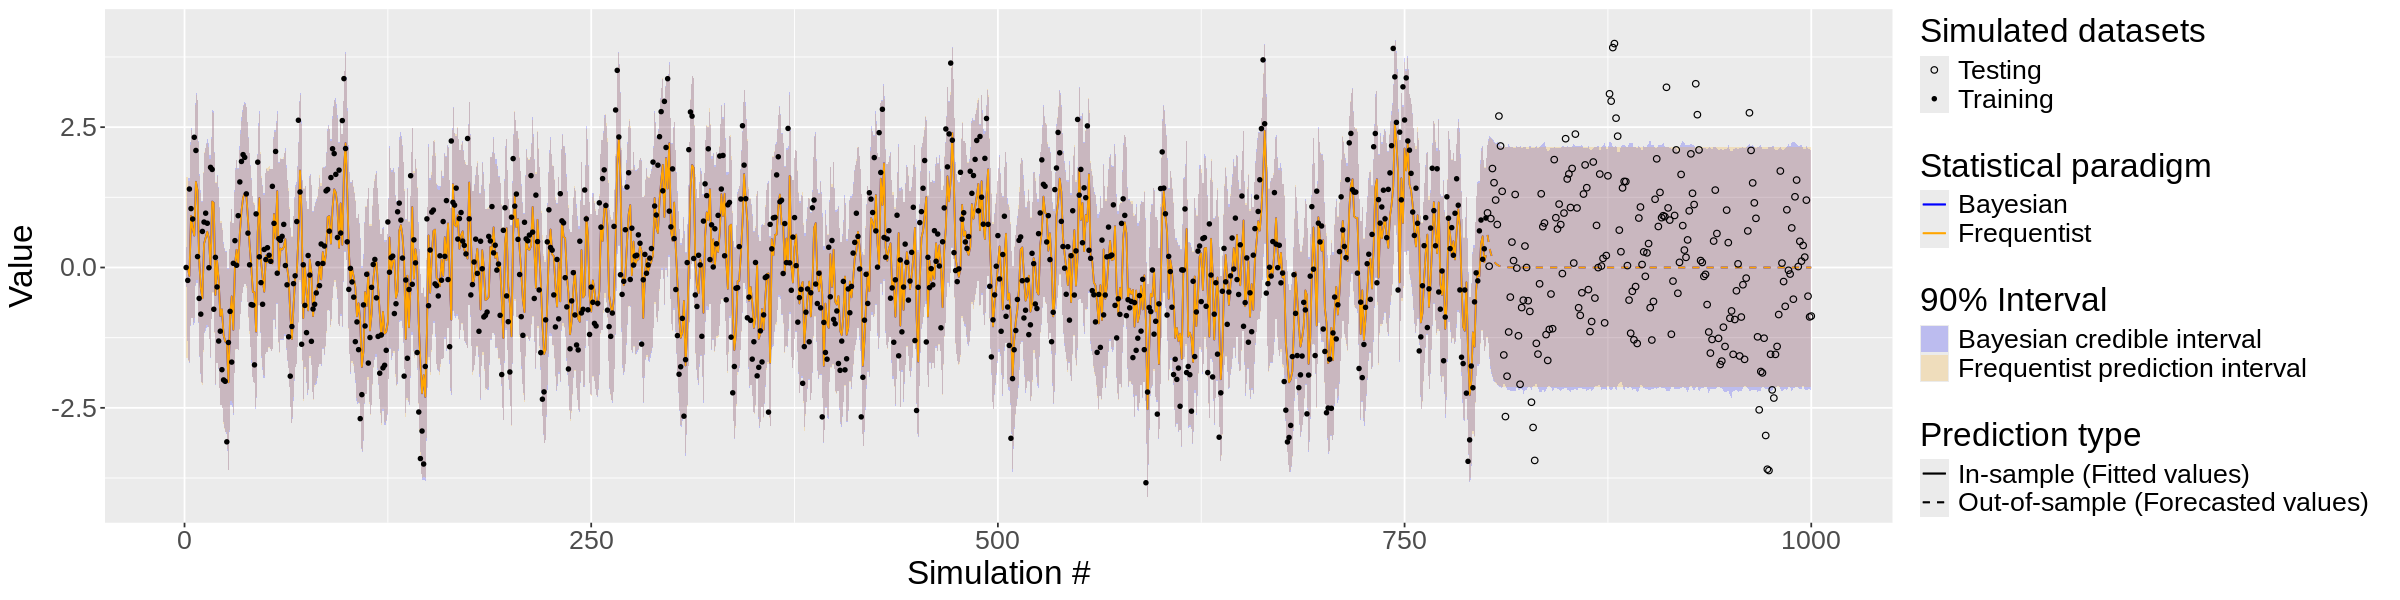

In [ ]:
# Parameters
phi <- 0.7
order <- c(1, 0, 0)

# Generate AR(1) process
errors <- rnorm(size, mean = 0, sd = 1)
x <- numeric(size)
x[1] <- 0  # Initial value
for (i in 2:size) {
  x[i] <- phi * x[i - 1] + errors[i]
}

# Split observed and future values
x_observed <- head(x, size - h)
x_future <- tail(x, h)

# Fit ARIMA models
frequentist_fit <- arima(x = x_observed, order = order, include.mean = FALSE)
bayesian_fit <- bayesian_arima(x = x_observed, order = order, h = h)

# Generate comparison plot
p1 <- comparison_plot(frequentist_fit, bayesian_fit, x_observed, x_future)
p1 + theme(text = element_text(size = 20))

In [ ]:
# Model comparison
fb_label <- c("Frequentist", "Bayesian")
phi1_recov_f <- frequentist_fit$coef[["ar1"]]
phi1_recov_b <- apply(rstan::extract(bayesian_fit, "phi")$phi, 2, mean)[1]

# Compute the closest model
closest_model <- fb_label[which.min(c(abs(phi1_recov_f - phi), abs(phi1_recov_b - phi)))]

cat("Phi parameter comparison\n")
cat("Actual: ", phi, "\n")
cat("Recovered by Bayesian model: ", round(phi1_recov_b, 3), "\n")
cat("Recovered by Frequentist model: ", round(phi1_recov_f, 3), "\n")
cat("Closest Model: ", closest_model, "\n")

Phi parameter comparison
Actual:  0.7 
Recovered by Bayesian model:  0.659 
Recovered by Frequentist model:  0.658 
Closest Model:  Bayesian 


ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



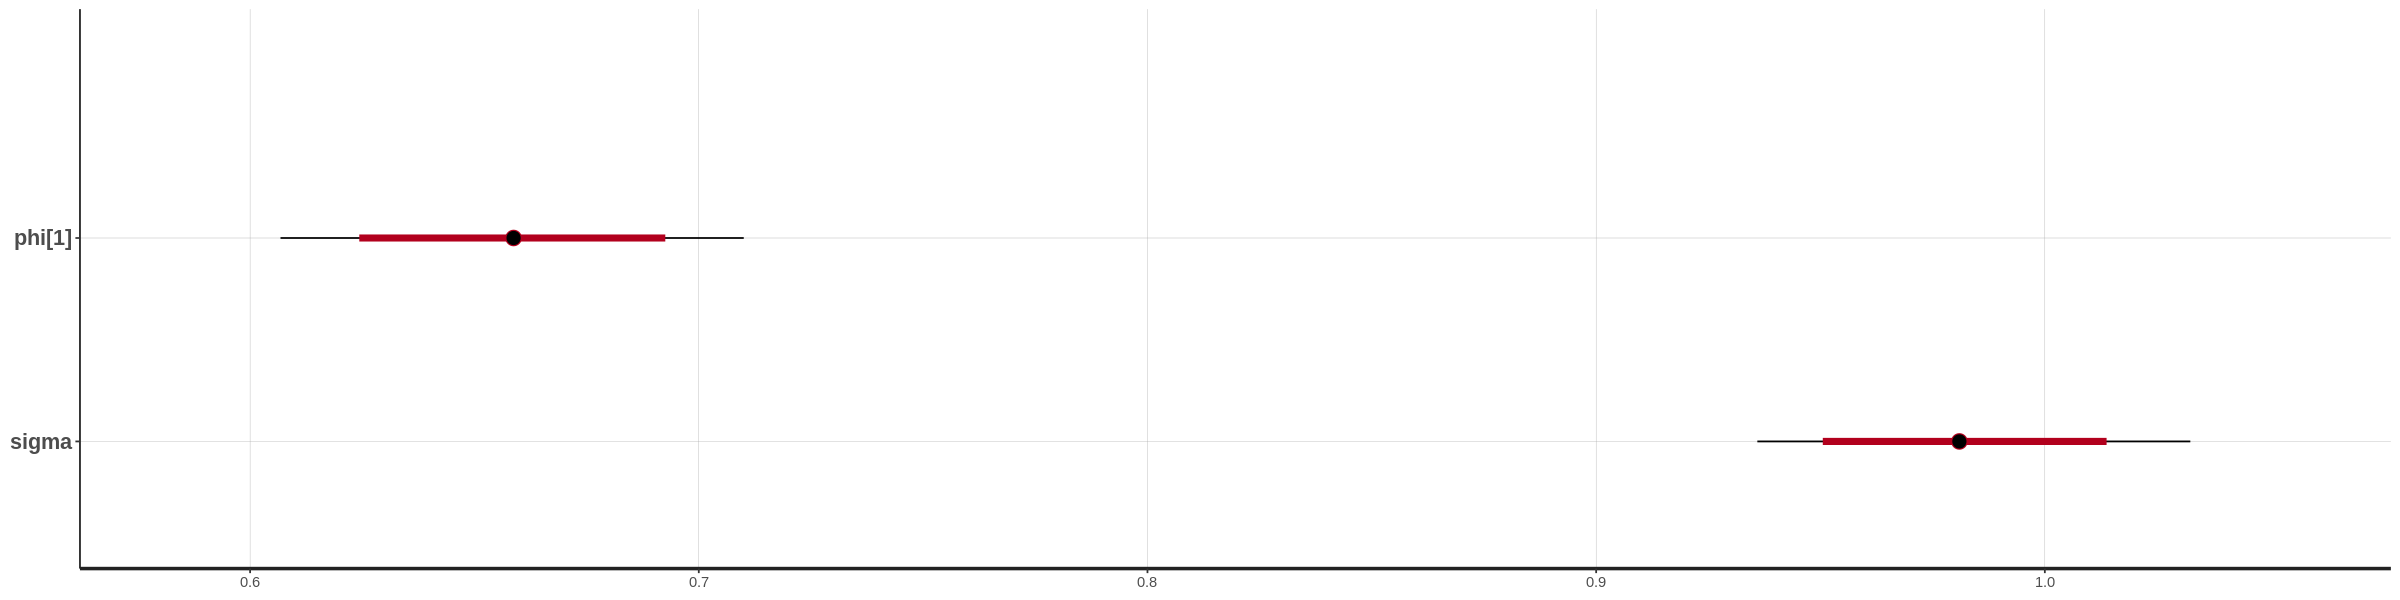

In [ ]:
plot(bayesian_fit, pars = c('phi', 'sigma'))

In [ ]:
coeftest(frequentist_fit)


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1 0.657821   0.026558   24.77 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


TK: note on credible intervals vs confidence interval.

### Process 3: Random Walk = ARIMA(0,1,0) = ARIMA(1,0,0) with $\phi = 1$

Data generating process: $x_t = x_{t-1} + \epsilon$, where $\epsilon \sim \text{Normal}(0,1)$. This is a special case of the ARIMA. Specifically, it corresponds to ARIMA(0,1,0), or, equivalently to an ARIMA(1,0,0) process with unit root, $\phi_1 = 1$.)

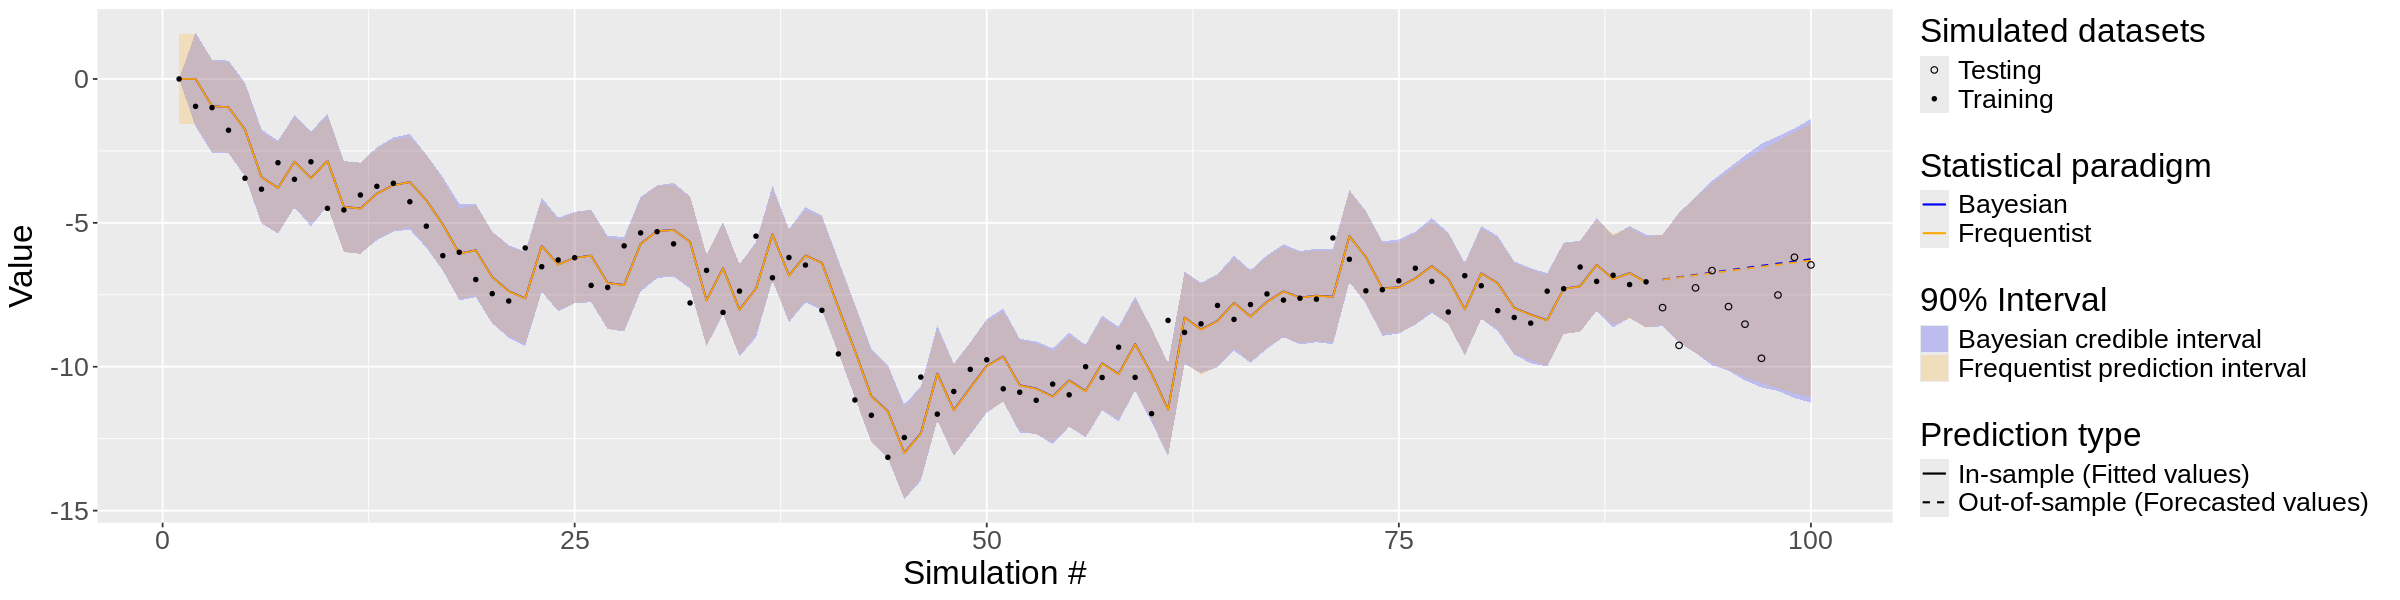

In [ ]:
# Parameters
phi <- 1
order <- c(1, 0, 0)

# Generate AR(1) process
errors <- rnorm(size, mean = 0, sd = 1)
x <- numeric(size)
x[1] <- 0  # Initial value for the AR process

# Generate the AR(1) process values
for (i in 2:size) {
  x[i] <- phi * x[i - 1] + errors[i]
}

# Split observed and future values
x_observed <- head(x, size - h)
x_future <- tail(x, h)

# Fit ARIMA models
frequentist_fit <- arima(x = x_observed, order = order, include.mean = FALSE)
bayesian_fit <- bayesian_arima(x = x_observed, order = order, h = h)

# Generate comparison plot
p1 <- comparison_plot(frequentist_fit, bayesian_fit, x_observed, x_future)
p1 + theme(text = element_text(size = 20))

In [ ]:
# Parameters comparison
fb_label <- c("Frequentist", "Bayesian")
phi1_recov_f <- frequentist_fit$coef[["ar1"]]
phi1_recov_b <- apply(rstan::extract(bayesian_fit, "phi")$phi, 2, mean)[1]

# Compute the closest model
closest_model <- fb_label[which.min(c(abs(phi1_recov_f - phi), abs(phi1_recov_b - phi)))]

cat("Phi parameter comparison\n")
cat("Actual: ", phi, "\n")
cat("Recovered by Bayesian model: ", round(phi1_recov_b, 3), "\n")
cat("Recovered by Frequentist model: ", round(phi1_recov_f, 3), "\n")
cat("Closest Model: ", closest_model, "\n")

Phi parameter comparison
Actual:  1 
Recovered by Bayesian model:  0.959 
Recovered by Frequentist model:  0.959 
Closest Model:  Bayesian 


### Process 4: Moving Average Model = ARIMA(0,0,1)

In [ ]:
# Parameters
theta <- 0.2  # MA coefficient
order <- c(0, 0, 1)  # ARIMA(0, 0, 1) model

# Preallocate memory for x and error
x <- numeric(size)
error <- rnorm(size, mean = 0, sd = 1)

# Generate the MA(1) process
for (i in 2:size) {
  x[i] <- error[i - 1] * theta + error[i]
}

# Split the data into observed and future values
x_observed <- x[1:(size - h)]
x_future <- x[(size - h + 1):size]

# Fit ARIMA models
frequentist_fit <- arima(x = x_observed, order = order, include.mean = FALSE)
bayesian_fit <- bayesian_arima(x = x_observed, order = order, h = h)

# Generate comparison plot
p1 <- comparison_plot(frequentist_fit, bayesian_fit, x_observed, x_future)
p1 + theme(text = element_text(size = 20))


# 6. Conclusion <a name="conclusion"></a>

### To do/TK: clarifications about the forecast model being used for forecasting the uncertainty of the stats arima model. This makes it inherently bayesian.